In [1]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer, GaussianNoise, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import (recall_score,  precision_score, f1_score, roc_auc_score,
                             make_scorer, confusion_matrix)

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils import class_weight


import random as rd
from skimage import io
from matplotlib import pyplot as plt
import time

/home/rpezoa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/rpezoa/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
base_dir = "/home/rpezoa/experiment_data/"
images=["2+_9"]
type_im = ["2+"]
feat = "rpr"
feat_path = base_dir + "big_" + type_im[0] +"/features/" + images[0] + "_" + feat + ".npy"
label_path = base_dir + "big_" + type_im[0] + "/labels/" + images[0] + ".npy"
blue_path = base_dir + "big_" + type_im[0] +"/features/" + images[0] + "_b.npy"
#dab_path = base_dir + "big_" + type_im[0] +"/features/" + images[0] + "_dab.npy"
print(feat_path, label_path)

/home/rpezoa/experiment_data/big_2+/features/2+_9_rpr.npy /home/rpezoa/experiment_data/big_2+/labels/2+_9.npy


In [3]:
img_path = base_dir +"big_" + type_im[0] + "/img/" + images[0] + ".tif"
img = io.imread(img_path)

In [4]:
X = np.load(feat_path)
blue = np.load(blue_path)
#dab = np.load(dab_path)
n_feat = X.shape[1]
print("N feat:", n_feat)
y = np.load(label_path)
print(X.shape, y.shape)

N feat: 40
(1000000, 40) (1000000,)


In [5]:
def training_data(X,y, method="strati", size=13005, p_class1=0.3,seed=0):
    if method == "strati":
        mask_0 = y == 0
        mask_1 = y == 1
        idx_0 = np.where(mask_0 == True)[0] #indices of pixels with target equal 0 (non-mem) 
        idx_1 = np.where(mask_1 == True)[0] #indices of pixels with target equal 1 (mem)
        print("idx_0.shape", idx_0.shape, "idx_1.shape", idx_1.shape)
        n_0 = mask_0.sum()

        n_1 = mask_1.sum()
        print("non-mem:", n_0, "mem:", n_1)
        y_0 = y[mask_0]
        y_1 = y[mask_1]

        X_0 = X[mask_0] #only non-mem
        X_1 = X[mask_1] #only mem
        print("X_0.shape, X_1.shape", X_0.shape, X_1.shape)

        rd.seed(seed)
        rd_idx_0 = rd.sample(range(n_0),int((1-p_class1) * size))
        rd_idx_1 = rd.sample(range(n_1),int(p_class1 * size))


        X_0 = X_0[rd_idx_0,:]
        X_1 = X_1[rd_idx_1,:]

        y_0 = y_0[rd_idx_0]
        y_1 = y_1[rd_idx_1]

        new_idx_0 = idx_0[rd_idx_0]
        new_idx_1 = idx_1[rd_idx_1]

        rd_X = np.concatenate((X_0,X_1),axis=0)
        rd_y = np.concatenate((y_0,y_1),axis=0)
        print("X.shape:", rd_X.shape, "y.shape", rd_y.shape)
        return rd_X, rd_y,new_idx_0,new_idx_1
    

In [6]:
def matrix_indices(a,dim=(1000,1000)):
    idxs = np.unravel_index(a, dim)
    return idxs

In [7]:
def show_training_pixels(big_im,idxs1,idxs2):
    n = idxs1[0].shape[0]
    the_im2 = big_im[:,:,0:3].copy()
    for i in range(n):
        the_im2[idxs1[0][i],idxs1[1][i],0] = 0
        the_im2[idxs1[0][i],idxs1[1][i],1] = 0
        the_im2[idxs1[0][i],idxs1[1][i],2] = 255
        
    n2 = idxs2[0].shape[0]
    for i in range(n2):
        the_im2[idxs2[0][i],idxs2[1][i],0] = 255
        the_im2[idxs2[0][i],idxs2[1][i],1] = 0
        the_im2[idxs2[0][i],idxs2[1][i],2] = 0
    
    return the_im2

In [8]:
def f1_(y_true, y_pred):
    def recall_(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
def get_model():

    
    classifier = Sequential()
    # Adding the input layer and the first hidden layer with dropout
    print("initial dim:", initial_dim)
    classifier.add(Dense(activation = 'relu', input_dim = initial_dim, units = 8, kernel_initializer = 'uniform'))
    #Randomly drops 0.1, 10% of the neurons in the layer.
    classifier.add(Dropout(rate= 0.1))

    #Adding the second hidden layer
    classifier.add(Dense(activation = 'relu', units = 8, kernel_initializer = 'uniform'))
    #Randomly drops 0.1, 10% of the neurons in the layer.
    classifier.add(Dropout(rate = 0.1))

    # Adding the output layer
    classifier.add(Dense(activation = 'sigmoid', units = 1, kernel_initializer = 'uniform'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_])
    
    return classifier

def ann(X,y,big_X):
    t1 = time.time()
    clf  = KerasClassifier(build_fn=get_model)
    epochs  = [100,300,500]
    batch_size = [100,350,1000]
    shuffle = [False]
    class_weights = [class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)]
    print(class_weights,X.shape[1])
    param_grid = dict(epochs=epochs, batch_size=batch_size, class_weight=class_weights,shuffle=shuffle)
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=1,cv=2, scoring="f1", verbose=1)
    # Fitting the ANN to the training set
    #classifier.fit(X, y, batch_size = 200, epochs = 300, class_weight =class_weights, 
                   #shuffle=False,verbose=1)
    print("---------1",grid)
    grid_result = grid.fit(X,y)
    print("---------2")

    pred_big_im = grid_result.best_estimator_.predict(big_X)
    pred_training = grid_result.best_estimator_.predict(X)
    pred_testing = grid_result.best_estimator_.predict(test)
    #clf.fit(x_train, y_train, batch_size = 10, nb_epoch = 1000)
    #pred_big_im = clf.predict(big_scaled_feat_matrix)
    pred_big_im = (pred_big_im > 0.5)
    pred_training = (pred_training > 0.5)
    pred_testing = (pred_testing > 0.5)
    t2 = time.time()
    t = t2 - t1
    print("Time:::::::", t)
    print("Best: %f using %s"% (grid_result.best_score_, grid_result.best_params_))
    return pred_training, pred_big_im, pred_testing


In [10]:
def print_metrics(s,target,prediction):
    cm = confusion_matrix(target, prediction)
    print("-"*10,s,"-"*10)
    print(cm)
    f1 = f1_score(target,prediction)
    prec = recall_score(target, prediction)
    rec = precision_score(target,prediction)
    print("f1", f1)
    print("rec", prec)
    print("prec", rec)
    print("roc", roc_auc_score(target,prediction))
    return cm, f1,prec,rec

In [11]:
def measure_bronw(c,t='auto'):
    plt.hist(c, bins=t)  # arguments are passed to np.histogram
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [12]:
sizes = [20000]#, 2000, 5000,10000]
percs = [0.2]
F1 = np.zeros((len(sizes),3))
PREC = np.zeros((len(sizes),3))
REC = np.zeros((len(sizes),3))
TIME = np.zeros((len(sizes),1))
for i,s in enumerate(sizes):
    for per in percs:
        x_train, y_train,idx_0,idx_1 = training_data(X,y,size=s,p_class1=per) #size=20000,p_class1=0.2)
        m_idx0 = matrix_indices(idx_0)
        m_idx1 = matrix_indices(idx_1)
        #img_2 = show_training_pixels(img,m_idx0,m_idx1)
        #plt.figure(figsize=(14,14))
        #plt.imshow(img_2)
        #plt.show()
        
        x_train_2, x_test, y_train_2, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
        sfm = SelectFromModel(LassoCV())
        sfm.fit(x_train_2, y_train_2)
        train = sfm.transform(x_train_2)
        test = sfm.transform(x_test)
        XX = sfm.transform(X)

        initial_dim = train.shape[1]
        #pred_training, pred_big_im, pred_testing = ann(x_train_2,y_train_2,X)
        pred_training, pred_big_im, pred_testing = ann(train,y_train_2,XX)
        cm_train,F1[i,0],REC[i,0],PREC[i,0] = print_metrics("Trainng",y_train_2,pred_training)
        cm_test,F1[i,1],REC[i,1],PREC[i,1] = print_metrics("Test",y_test, pred_testing)
        cm_big,F1[i,2],REC[i,2],PREC[i,2] = print_metrics("Big image",y,pred_big_im)

idx_0.shape (964483,) idx_1.shape (35517,)
non-mem: 964483 mem: 35517
X_0.shape, X_1.shape (964483, 40) (35517, 40)
X.shape: (20000, 40) y.shape (20000,)


/home/rpezoa/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[array([0.625, 2.5  ])] 19
---------1 GridSearchCV(cv=2, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff115bd43c8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [100, 300, 500], 'batch_size': [100, 350, 1000], 'class_weight': [array([0.625, 2.5  ])], 'shuffle': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)
Fitting 2 folds for each of 9 candidates, totalling 18 fits
initial dim: 19
Epoch 1/100
8000/8000 [==============================] - 0s 41us/step - loss: 0.6755 - f1_: 9.8684e-04
Epoch 2/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.5550 - f1_: 0.2402
Epoch 3/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.3200 - f1_: 0.7044
Epoch 4/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.2195 - f1_: 0.7685
Epoch 5/100
8000/8000 [==============================] - 0s 15us/step 

8000/8000 [==============================] - 0s 15us/step - loss: 0.1678 - f1_: 0.8166
Epoch 78/100
8000/8000 [==============================] - 0s 13us/step - loss: 0.1651 - f1_: 0.8223
Epoch 79/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.1634 - f1_: 0.8196
Epoch 80/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1633 - f1_: 0.8205
Epoch 81/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1665 - f1_: 0.8185
Epoch 82/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1645 - f1_: 0.8168
Epoch 83/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1659 - f1_: 0.8182
Epoch 84/100
8000/8000 [==============================] - 0s 13us/step - loss: 0.1647 - f1_: 0.8196
Epoch 85/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.1652 - f1_: 0.8199
Epoch 86/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.1655 - f1_: 0.8149
Epoch 87/100


Epoch 59/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.1609 - f1_: 0.8284
Epoch 60/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1634 - f1_: 0.8240
Epoch 61/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1637 - f1_: 0.8246
Epoch 62/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1623 - f1_: 0.8228
Epoch 63/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1644 - f1_: 0.8232
Epoch 64/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1636 - f1_: 0.8261
Epoch 65/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1620 - f1_: 0.8276
Epoch 66/100
8000/8000 [==============================] - 0s 14us/step - loss: 0.1637 - f1_: 0.8245
Epoch 67/100
8000/8000 [==============================] - 0s 13us/step - loss: 0.1632 - f1_: 0.8211
Epoch 68/100
8000/8000 [==============================] - 0s 15us/step - loss: 0.1626 - f1_: 0.8236


8000/8000 [==============================] - 0s 16us/step - loss: 0.1806 - f1_: 0.8227
Epoch 41/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1770 - f1_: 0.8216
Epoch 42/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1783 - f1_: 0.8168
Epoch 43/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1787 - f1_: 0.8157
Epoch 44/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1785 - f1_: 0.8221
Epoch 45/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1778 - f1_: 0.8216
Epoch 46/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1776 - f1_: 0.8196
Epoch 47/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1767 - f1_: 0.8198
Epoch 48/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1754 - f1_: 0.8197
Epoch 49/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1751 - f1_: 0.8161
Epoch 50/300


8000/8000 [==============================] - 0s 15us/step - loss: 0.1696 - f1_: 0.8236
Epoch 122/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1699 - f1_: 0.8276
Epoch 123/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1697 - f1_: 0.8277
Epoch 124/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1726 - f1_: 0.8177
Epoch 125/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1716 - f1_: 0.8212
Epoch 126/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1713 - f1_: 0.8255
Epoch 127/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1685 - f1_: 0.8211
Epoch 128/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1693 - f1_: 0.8235
Epoch 129/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1699 - f1_: 0.8229
Epoch 130/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1702 - f1_: 0.8183
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1693 - f1_: 0.8139
Epoch 203/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1669 - f1_: 0.8258
Epoch 204/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1703 - f1_: 0.8243
Epoch 205/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1673 - f1_: 0.8242
Epoch 206/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1646 - f1_: 0.8315
Epoch 207/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1663 - f1_: 0.8229
Epoch 208/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1681 - f1_: 0.8175
Epoch 209/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1698 - f1_: 0.8247
Epoch 210/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1711 - f1_: 0.8228
Epoch 211/300
8000/8000 [==============================] - 0s 16us/step - loss: 0.1655 - f1_: 0.8266
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1663 - f1_: 0.8306
Epoch 284/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1690 - f1_: 0.8214
Epoch 285/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1669 - f1_: 0.8208
Epoch 286/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1670 - f1_: 0.8208
Epoch 287/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1672 - f1_: 0.8243
Epoch 288/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1646 - f1_: 0.8268
Epoch 289/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1663 - f1_: 0.8214
Epoch 290/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1688 - f1_: 0.8204
Epoch 291/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1660 - f1_: 0.8279
Epoch 292/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1649 - f1_: 0.8267
Epoc

8000/8000 [==============================] - 0s 15us/step - loss: 0.1717 - f1_: 0.8194
Epoch 65/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1701 - f1_: 0.8195
Epoch 66/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1706 - f1_: 0.8192
Epoch 67/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1720 - f1_: 0.8206
Epoch 68/300
8000/8000 [==============================] - 0s 17us/step - loss: 0.1672 - f1_: 0.8314
Epoch 69/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1682 - f1_: 0.8258
Epoch 70/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1715 - f1_: 0.8153
Epoch 71/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1703 - f1_: 0.8148
Epoch 72/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1684 - f1_: 0.8146
Epoch 73/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1680 - f1_: 0.8240
Epoch 74/300


8000/8000 [==============================] - 0s 16us/step - loss: 0.1630 - f1_: 0.8208
Epoch 146/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1619 - f1_: 0.8225
Epoch 147/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1634 - f1_: 0.8194
Epoch 148/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1620 - f1_: 0.8255
Epoch 149/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1635 - f1_: 0.8230
Epoch 150/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1611 - f1_: 0.8254
Epoch 151/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1662 - f1_: 0.8229
Epoch 152/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1606 - f1_: 0.8160
Epoch 153/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1613 - f1_: 0.8248
Epoch 154/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1638 - f1_: 0.8232
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1556 - f1_: 0.8325
Epoch 227/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1583 - f1_: 0.8213
Epoch 228/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1561 - f1_: 0.8250
Epoch 229/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1550 - f1_: 0.8311
Epoch 230/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1599 - f1_: 0.8182
Epoch 231/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1605 - f1_: 0.8155
Epoch 232/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1589 - f1_: 0.8215
Epoch 233/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1596 - f1_: 0.8269
Epoch 234/300
8000/8000 [==============================] - 0s 14us/step - loss: 0.1578 - f1_: 0.8245
Epoch 235/300
8000/8000 [==============================] - 0s 15us/step - loss: 0.1548 - f1_: 0.8291
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1970 - f1_: 0.7273
Epoch 8/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1945 - f1_: 0.7220
Epoch 9/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1947 - f1_: 0.7344
Epoch 10/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1922 - f1_: 0.7394
Epoch 11/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1899 - f1_: 0.7423
Epoch 12/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1876 - f1_: 0.7608
Epoch 13/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1855 - f1_: 0.7761
Epoch 14/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1844 - f1_: 0.7697
Epoch 15/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1857 - f1_: 0.7682
Epoch 16/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1873 - f1_: 0.7953
Epoch 17/500
80

8000/8000 [==============================] - 0s 16us/step - loss: 0.1680 - f1_: 0.8213
Epoch 90/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1709 - f1_: 0.8212
Epoch 91/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1699 - f1_: 0.8244
Epoch 92/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1690 - f1_: 0.8219
Epoch 93/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1669 - f1_: 0.8252
Epoch 94/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1711 - f1_: 0.8223
Epoch 95/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1692 - f1_: 0.8255
Epoch 96/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1713 - f1_: 0.8263
Epoch 97/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1687 - f1_: 0.8214
Epoch 98/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1695 - f1_: 0.8202
Epoch 99/500


8000/8000 [==============================] - 0s 17us/step - loss: 0.1666 - f1_: 0.8246
Epoch 171/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1665 - f1_: 0.8253
Epoch 172/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1632 - f1_: 0.8245
Epoch 173/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1683 - f1_: 0.8221
Epoch 174/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1658 - f1_: 0.8226
Epoch 175/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1635 - f1_: 0.8247
Epoch 176/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1664 - f1_: 0.8269
Epoch 177/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1663 - f1_: 0.8249
Epoch 178/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1630 - f1_: 0.8285
Epoch 179/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1688 - f1_: 0.8238
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1632 - f1_: 0.8255
Epoch 252/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1664 - f1_: 0.8222
Epoch 253/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1651 - f1_: 0.8242
Epoch 254/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1623 - f1_: 0.8243
Epoch 255/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1639 - f1_: 0.8273
Epoch 256/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1627 - f1_: 0.8258
Epoch 257/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1608 - f1_: 0.8257
Epoch 258/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1619 - f1_: 0.8235
Epoch 259/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1636 - f1_: 0.8283
Epoch 260/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1633 - f1_: 0.8295
Epoc

8000/8000 [==============================] - 0s 18us/step - loss: 0.1613 - f1_: 0.8274
Epoch 333/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1622 - f1_: 0.8280
Epoch 334/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1607 - f1_: 0.8299
Epoch 335/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1642 - f1_: 0.8288
Epoch 336/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1636 - f1_: 0.8307
Epoch 337/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1648 - f1_: 0.8257
Epoch 338/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1619 - f1_: 0.8279
Epoch 339/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1642 - f1_: 0.8265
Epoch 340/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1627 - f1_: 0.8284
Epoch 341/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1623 - f1_: 0.8291
Epoc

8000/8000 [==============================] - 0s 15us/step - loss: 0.1626 - f1_: 0.8278
Epoch 414/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1641 - f1_: 0.8328
Epoch 415/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1624 - f1_: 0.8274
Epoch 416/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1620 - f1_: 0.8296
Epoch 417/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1611 - f1_: 0.8314
Epoch 418/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1613 - f1_: 0.8281
Epoch 419/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1630 - f1_: 0.8257
Epoch 420/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1608 - f1_: 0.8272
Epoch 421/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1631 - f1_: 0.8256
Epoch 422/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1637 - f1_: 0.8292
Epoc

8000/8000 [==============================] - 0s 15us/step - loss: 0.1610 - f1_: 0.8303
Epoch 495/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1609 - f1_: 0.8315
Epoch 496/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1649 - f1_: 0.8329
Epoch 497/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1615 - f1_: 0.8313
Epoch 498/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1610 - f1_: 0.8307
Epoch 499/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1602 - f1_: 0.8312
Epoch 500/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1617 - f1_: 0.8231
initial dim: 19
Epoch 1/500
8000/8000 [==============================] - 0s 59us/step - loss: 0.6660 - f1_: 0.0000e+00
Epoch 2/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.4896 - f1_: 0.0000e+00
Epoch 3/500
8000/8000 [==============================] - 0s 17us/step - loss: 0.2958 

8000/8000 [==============================] - 0s 16us/step - loss: 0.1668 - f1_: 0.8212
Epoch 76/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1661 - f1_: 0.8203
Epoch 77/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1669 - f1_: 0.8179
Epoch 78/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1636 - f1_: 0.8259
Epoch 79/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1632 - f1_: 0.8219
Epoch 80/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1652 - f1_: 0.8271
Epoch 81/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1639 - f1_: 0.8217
Epoch 82/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1667 - f1_: 0.8159
Epoch 83/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1641 - f1_: 0.8230
Epoch 84/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1644 - f1_: 0.8154
Epoch 85/500


8000/8000 [==============================] - 0s 16us/step - loss: 0.1633 - f1_: 0.8199
Epoch 157/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1614 - f1_: 0.8255
Epoch 158/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1610 - f1_: 0.8283
Epoch 159/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1604 - f1_: 0.8297
Epoch 160/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1596 - f1_: 0.8305
Epoch 161/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1601 - f1_: 0.8282
Epoch 162/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1614 - f1_: 0.8278
Epoch 163/500
8000/8000 [==============================] - 0s 17us/step - loss: 0.1594 - f1_: 0.8257
Epoch 164/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1623 - f1_: 0.8226
Epoch 165/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1611 - f1_: 0.8236
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1568 - f1_: 0.8284
Epoch 238/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1583 - f1_: 0.8243
Epoch 239/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1584 - f1_: 0.8270
Epoch 240/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1573 - f1_: 0.8278
Epoch 241/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1552 - f1_: 0.8311
Epoch 242/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1559 - f1_: 0.8300
Epoch 243/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1552 - f1_: 0.8291
Epoch 244/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1547 - f1_: 0.8283
Epoch 245/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1566 - f1_: 0.8250
Epoch 246/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1559 - f1_: 0.8254
Epoc

8000/8000 [==============================] - 0s 16us/step - loss: 0.1540 - f1_: 0.8286
Epoch 319/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1551 - f1_: 0.8240
Epoch 320/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1556 - f1_: 0.8259
Epoch 321/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1535 - f1_: 0.8295
Epoch 322/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1555 - f1_: 0.8316
Epoch 323/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1542 - f1_: 0.8289
Epoch 324/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1552 - f1_: 0.8270
Epoch 325/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1555 - f1_: 0.8262
Epoch 326/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1545 - f1_: 0.8296
Epoch 327/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1528 - f1_: 0.8354
Epoc

8000/8000 [==============================] - 0s 15us/step - loss: 0.1552 - f1_: 0.8278
Epoch 400/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1524 - f1_: 0.8293
Epoch 401/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1532 - f1_: 0.8280
Epoch 402/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1544 - f1_: 0.8311
Epoch 403/500
8000/8000 [==============================] - 0s 14us/step - loss: 0.1553 - f1_: 0.8293
Epoch 404/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1531 - f1_: 0.8289
Epoch 405/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1558 - f1_: 0.8309
Epoch 406/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1540 - f1_: 0.8276
Epoch 407/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1526 - f1_: 0.8288
Epoch 408/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1548 - f1_: 0.8229
Epoc

8000/8000 [==============================] - 0s 15us/step - loss: 0.1549 - f1_: 0.8162
Epoch 481/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1530 - f1_: 0.8220
Epoch 482/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1534 - f1_: 0.8241
Epoch 483/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1537 - f1_: 0.8202
Epoch 484/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1552 - f1_: 0.8246
Epoch 485/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1518 - f1_: 0.8253
Epoch 486/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1528 - f1_: 0.8240
Epoch 487/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1546 - f1_: 0.8239
Epoch 488/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.1523 - f1_: 0.8302
Epoch 489/500
8000/8000 [==============================] - 0s 16us/step - loss: 0.1542 - f1_: 0.8232
Epoc

8000/8000 [==============================] - 0s 6us/step - loss: 0.1844 - f1_: 0.8142
Epoch 63/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1783 - f1_: 0.8154
Epoch 64/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1821 - f1_: 0.8157
Epoch 65/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1811 - f1_: 0.8198
Epoch 66/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1814 - f1_: 0.8196
Epoch 67/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1802 - f1_: 0.8145
Epoch 68/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1801 - f1_: 0.8182
Epoch 69/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1800 - f1_: 0.8212
Epoch 70/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1795 - f1_: 0.8200
Epoch 71/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1815 - f1_: 0.8166
Epoch 72/100
8000/8000 

8000/8000 [==============================] - 0s 7us/step - loss: 0.1813 - f1_: 0.7750
Epoch 45/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1803 - f1_: 0.7798
Epoch 46/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1822 - f1_: 0.7717
Epoch 47/100
8000/8000 [==============================] - 0s 7us/step - loss: 0.1802 - f1_: 0.7817
Epoch 48/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1806 - f1_: 0.7712
Epoch 49/100
8000/8000 [==============================] - 0s 5us/step - loss: 0.1809 - f1_: 0.7754
Epoch 50/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1796 - f1_: 0.7809
Epoch 51/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1837 - f1_: 0.7757
Epoch 52/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1766 - f1_: 0.7854
Epoch 53/100
8000/8000 [==============================] - 0s 6us/step - loss: 0.1817 - f1_: 0.7747
Epoch 54/100
8000/8000 

8000/8000 [==============================] - 0s 6us/step - loss: 0.1943 - f1_: 0.7783
Epoch 27/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1917 - f1_: 0.7751
Epoch 28/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1941 - f1_: 0.7703
Epoch 29/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1912 - f1_: 0.7780
Epoch 30/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1883 - f1_: 0.7826
Epoch 31/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1879 - f1_: 0.7744
Epoch 32/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1881 - f1_: 0.7789
Epoch 33/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1893 - f1_: 0.7762
Epoch 34/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1891 - f1_: 0.7824
Epoch 35/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1888 - f1_: 0.7740
Epoch 36/300
8000/8000 

8000/8000 [==============================] - 0s 10us/step - loss: 0.1806 - f1_: 0.7911
Epoch 109/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1777 - f1_: 0.7907
Epoch 110/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1784 - f1_: 0.7915
Epoch 111/300
8000/8000 [==============================] - 0s 7us/step - loss: 0.1801 - f1_: 0.7885
Epoch 112/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1799 - f1_: 0.7937
Epoch 113/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1768 - f1_: 0.7940
Epoch 114/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1768 - f1_: 0.7925
Epoch 115/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1777 - f1_: 0.7942
Epoch 116/300
8000/8000 [==============================] - 0s 7us/step - loss: 0.1773 - f1_: 0.7941
Epoch 117/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1793 - f1_: 0.7888
Epoch 118/300

8000/8000 [==============================] - 0s 6us/step - loss: 0.1750 - f1_: 0.7942
Epoch 191/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1744 - f1_: 0.7864
Epoch 192/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1743 - f1_: 0.7906
Epoch 193/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1754 - f1_: 0.7898
Epoch 194/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1761 - f1_: 0.7837
Epoch 195/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1727 - f1_: 0.7942
Epoch 196/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1746 - f1_: 0.7924
Epoch 197/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1755 - f1_: 0.7843
Epoch 198/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1743 - f1_: 0.7873
Epoch 199/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1701 - f1_: 0.7961
Epoch 200/300


8000/8000 [==============================] - 0s 7us/step - loss: 0.1733 - f1_: 0.7967
Epoch 273/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1727 - f1_: 0.7887
Epoch 274/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1701 - f1_: 0.7896
Epoch 275/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1716 - f1_: 0.7911
Epoch 276/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1694 - f1_: 0.7932
Epoch 277/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1707 - f1_: 0.7935
Epoch 278/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1709 - f1_: 0.7913
Epoch 279/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1710 - f1_: 0.7992
Epoch 280/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1702 - f1_: 0.7961
Epoch 281/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1716 - f1_: 0.7857
Epoch 282/300


8000/8000 [==============================] - 0s 6us/step - loss: 0.1766 - f1_: 0.8213
Epoch 55/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1794 - f1_: 0.8105
Epoch 56/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1837 - f1_: 0.8081
Epoch 57/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1798 - f1_: 0.8136
Epoch 58/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1802 - f1_: 0.8087
Epoch 59/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1783 - f1_: 0.8242
Epoch 60/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1783 - f1_: 0.8132
Epoch 61/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1775 - f1_: 0.8145
Epoch 62/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1795 - f1_: 0.8164
Epoch 63/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1771 - f1_: 0.8136
Epoch 64/300
8000/8000 

8000/8000 [==============================] - 0s 6us/step - loss: 0.1664 - f1_: 0.8283
Epoch 137/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1682 - f1_: 0.8255
Epoch 138/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1681 - f1_: 0.8314
Epoch 139/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1704 - f1_: 0.8240
Epoch 140/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1706 - f1_: 0.8258
Epoch 141/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1693 - f1_: 0.8274
Epoch 142/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1683 - f1_: 0.8315
Epoch 143/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1680 - f1_: 0.8319
Epoch 144/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1669 - f1_: 0.8289
Epoch 145/300
8000/8000 [==============================] - 0s 5us/step - loss: 0.1653 - f1_: 0.8303
Epoch 146/300


8000/8000 [==============================] - 0s 6us/step - loss: 0.1598 - f1_: 0.8365
Epoch 219/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1622 - f1_: 0.8357
Epoch 220/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1640 - f1_: 0.8358
Epoch 221/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1643 - f1_: 0.8311
Epoch 222/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1646 - f1_: 0.8342
Epoch 223/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1656 - f1_: 0.8349
Epoch 224/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1641 - f1_: 0.8307
Epoch 225/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1652 - f1_: 0.8332
Epoch 226/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1630 - f1_: 0.8346
Epoch 227/300
8000/8000 [==============================] - 0s 6us/step - loss: 0.1638 - f1_: 0.8329
Epoch 228/300


8000/8000 [==============================] - 0s 6us/step - loss: 0.1630 - f1_: 0.8342
initial dim: 19
Epoch 1/500
8000/8000 [==============================] - 1s 67us/step - loss: 0.6890 - f1_: 0.0145
Epoch 2/500
8000/8000 [==============================] - 0s 9us/step - loss: 0.6751 - f1_: 0.0000e+00
Epoch 3/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.6431 - f1_: 0.0049
Epoch 4/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.5778 - f1_: 0.1777
Epoch 5/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.4798 - f1_: 0.4339
Epoch 6/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.3760 - f1_: 0.6186
Epoch 7/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.2945 - f1_: 0.7351
Epoch 8/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.2455 - f1_: 0.7768
Epoch 9/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.2186 - f1_: 0.7773
Epoch 10/50

8000/8000 [==============================] - 0s 6us/step - loss: 0.1681 - f1_: 0.8265
Epoch 83/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1691 - f1_: 0.8217
Epoch 84/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1706 - f1_: 0.8221
Epoch 85/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1689 - f1_: 0.8247
Epoch 86/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1697 - f1_: 0.8201
Epoch 87/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1665 - f1_: 0.8273
Epoch 88/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1684 - f1_: 0.8191
Epoch 89/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1668 - f1_: 0.8256
Epoch 90/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1656 - f1_: 0.8278
Epoch 91/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1654 - f1_: 0.8238
Epoch 92/500
8000/8000 

8000/8000 [==============================] - 0s 6us/step - loss: 0.1614 - f1_: 0.8302
Epoch 165/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1643 - f1_: 0.8246
Epoch 166/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1595 - f1_: 0.8302
Epoch 167/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1619 - f1_: 0.8309
Epoch 168/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1613 - f1_: 0.8250
Epoch 169/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1644 - f1_: 0.8250
Epoch 170/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1618 - f1_: 0.8249
Epoch 171/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1628 - f1_: 0.8256
Epoch 172/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1632 - f1_: 0.8306
Epoch 173/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1612 - f1_: 0.8253
Epoch 174/500


8000/8000 [==============================] - 0s 6us/step - loss: 0.1596 - f1_: 0.8308
Epoch 247/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1604 - f1_: 0.8315
Epoch 248/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1613 - f1_: 0.8309
Epoch 249/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1609 - f1_: 0.8342
Epoch 250/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1587 - f1_: 0.8296
Epoch 251/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1602 - f1_: 0.8257
Epoch 252/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1588 - f1_: 0.8299
Epoch 253/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1608 - f1_: 0.8340
Epoch 254/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1619 - f1_: 0.8295
Epoch 255/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1600 - f1_: 0.8270
Epoch 256/500


Epoch 328/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1563 - f1_: 0.8299
Epoch 329/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1556 - f1_: 0.8284
Epoch 330/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1576 - f1_: 0.8264
Epoch 331/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1583 - f1_: 0.8308
Epoch 332/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1596 - f1_: 0.8266
Epoch 333/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1593 - f1_: 0.8278
Epoch 334/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1589 - f1_: 0.8267
Epoch 335/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1581 - f1_: 0.8332
Epoch 336/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1588 - f1_: 0.8288
Epoch 337/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1581 - f1_: 0.8355


8000/8000 [==============================] - 0s 6us/step - loss: 0.1573 - f1_: 0.8329
Epoch 410/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1575 - f1_: 0.8306
Epoch 411/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1570 - f1_: 0.8292
Epoch 412/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1575 - f1_: 0.8292
Epoch 413/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1553 - f1_: 0.8341
Epoch 414/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1554 - f1_: 0.8350
Epoch 415/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1569 - f1_: 0.8286
Epoch 416/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1580 - f1_: 0.8302
Epoch 417/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1579 - f1_: 0.8298
Epoch 418/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1589 - f1_: 0.8333
Epoch 419/500


8000/8000 [==============================] - 0s 6us/step - loss: 0.1555 - f1_: 0.8346
Epoch 492/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1549 - f1_: 0.8329
Epoch 493/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1560 - f1_: 0.8296
Epoch 494/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1566 - f1_: 0.8342
Epoch 495/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1556 - f1_: 0.8353
Epoch 496/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1563 - f1_: 0.8327
Epoch 497/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1541 - f1_: 0.8339
Epoch 498/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1573 - f1_: 0.8318
Epoch 499/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1551 - f1_: 0.8323
Epoch 500/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1577 - f1_: 0.8317
initial dim: 1

8000/8000 [==============================] - 0s 6us/step - loss: 0.1720 - f1_: 0.8180
Epoch 74/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1738 - f1_: 0.8182
Epoch 75/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1741 - f1_: 0.8210
Epoch 76/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1722 - f1_: 0.8241
Epoch 77/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1753 - f1_: 0.8208
Epoch 78/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1745 - f1_: 0.8149
Epoch 79/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1711 - f1_: 0.8231
Epoch 80/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1731 - f1_: 0.8213
Epoch 81/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1729 - f1_: 0.8249
Epoch 82/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1718 - f1_: 0.8243
Epoch 83/500
8000/8000 

8000/8000 [==============================] - 0s 7us/step - loss: 0.1663 - f1_: 0.8302
Epoch 156/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1654 - f1_: 0.8322
Epoch 157/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1655 - f1_: 0.8260
Epoch 158/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1652 - f1_: 0.8250
Epoch 159/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1641 - f1_: 0.8303
Epoch 160/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1653 - f1_: 0.8273
Epoch 161/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1657 - f1_: 0.8277
Epoch 162/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1639 - f1_: 0.8361
Epoch 163/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1638 - f1_: 0.8332
Epoch 164/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1651 - f1_: 0.8271
Epoch 165/500


8000/8000 [==============================] - 0s 6us/step - loss: 0.1620 - f1_: 0.8344
Epoch 238/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1607 - f1_: 0.8353
Epoch 239/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1608 - f1_: 0.8323
Epoch 240/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.1632 - f1_: 0.8370
Epoch 241/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1606 - f1_: 0.8340
Epoch 242/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1619 - f1_: 0.8335
Epoch 243/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1616 - f1_: 0.8373
Epoch 244/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1609 - f1_: 0.8351
Epoch 245/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1619 - f1_: 0.8388
Epoch 246/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1616 - f1_: 0.8336
Epoch 247/500


8000/8000 [==============================] - 0s 7us/step - loss: 0.1608 - f1_: 0.8357
Epoch 320/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1578 - f1_: 0.8389
Epoch 321/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1588 - f1_: 0.8391
Epoch 322/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1598 - f1_: 0.8396
Epoch 323/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1595 - f1_: 0.8378
Epoch 324/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1597 - f1_: 0.8367
Epoch 325/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1604 - f1_: 0.8381
Epoch 326/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1613 - f1_: 0.8374
Epoch 327/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1585 - f1_: 0.8359
Epoch 328/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1582 - f1_: 0.8404
Epoch 329/500


8000/8000 [==============================] - 0s 6us/step - loss: 0.1588 - f1_: 0.8372
Epoch 402/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1563 - f1_: 0.8427
Epoch 403/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1581 - f1_: 0.8387
Epoch 404/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1586 - f1_: 0.8422
Epoch 405/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1597 - f1_: 0.8344
Epoch 406/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1560 - f1_: 0.8420
Epoch 407/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1568 - f1_: 0.8407
Epoch 408/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1555 - f1_: 0.8399
Epoch 409/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1570 - f1_: 0.8402
Epoch 410/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1582 - f1_: 0.8317
Epoch 411/500


8000/8000 [==============================] - 0s 6us/step - loss: 0.1556 - f1_: 0.8377
Epoch 484/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1577 - f1_: 0.8381
Epoch 485/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1539 - f1_: 0.8401
Epoch 486/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1571 - f1_: 0.8327
Epoch 487/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1574 - f1_: 0.8390
Epoch 488/500
8000/8000 [==============================] - 0s 7us/step - loss: 0.1545 - f1_: 0.8433
Epoch 489/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1545 - f1_: 0.8399
Epoch 490/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1563 - f1_: 0.8391
Epoch 491/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1557 - f1_: 0.8403
Epoch 492/500
8000/8000 [==============================] - 0s 6us/step - loss: 0.1550 - f1_: 0.8400
Epoch 493/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.2030 - f1_: 0.7763
Epoch 66/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.2035 - f1_: 0.7757
Epoch 67/100
8000/8000 [==============================] - 0s 4us/step - loss: 0.2021 - f1_: 0.7729
Epoch 68/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.2023 - f1_: 0.7770
Epoch 69/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.2044 - f1_: 0.7695
Epoch 70/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1993 - f1_: 0.7861
Epoch 71/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.2011 - f1_: 0.7822
Epoch 72/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.2019 - f1_: 0.7781
Epoch 73/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1977 - f1_: 0.7839
Epoch 74/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1997 - f1_: 0.7846
Epoch 75/100
8000/8000 

8000/8000 [==============================] - 0s 3us/step - loss: 0.1927 - f1_: 0.8167
Epoch 48/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1902 - f1_: 0.8104
Epoch 49/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1930 - f1_: 0.8030
Epoch 50/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1905 - f1_: 0.8129
Epoch 51/100
8000/8000 [==============================] - 0s 4us/step - loss: 0.1899 - f1_: 0.8098
Epoch 52/100
8000/8000 [==============================] - 0s 4us/step - loss: 0.1887 - f1_: 0.8143
Epoch 53/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1887 - f1_: 0.8119
Epoch 54/100
8000/8000 [==============================] - 0s 4us/step - loss: 0.1895 - f1_: 0.8105
Epoch 55/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1855 - f1_: 0.8180
Epoch 56/100
8000/8000 [==============================] - 0s 3us/step - loss: 0.1842 - f1_: 0.8082
Epoch 57/100
8000/8000 

8000/8000 [==============================] - 0s 3us/step - loss: 0.5604 - f1_: 0.8188
Epoch 30/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5569 - f1_: 0.8206
Epoch 31/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5536 - f1_: 0.8224
Epoch 32/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5509 - f1_: 0.8194
Epoch 33/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5463 - f1_: 0.8212
Epoch 34/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5447 - f1_: 0.8219
Epoch 35/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5415 - f1_: 0.8254
Epoch 36/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5400 - f1_: 0.8227
Epoch 37/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.5378 - f1_: 0.8236
Epoch 38/300
8000/8000 [==============================] - 0s 4us/step - loss: 0.5356 - f1_: 0.8223
Epoch 39/300
8000/8000 

8000/8000 [==============================] - 0s 3us/step - loss: 0.3999 - f1_: 0.8249
Epoch 112/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3982 - f1_: 0.8234
Epoch 113/300
8000/8000 [==============================] - 0s 4us/step - loss: 0.3960 - f1_: 0.8228
Epoch 114/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3956 - f1_: 0.8231
Epoch 115/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3942 - f1_: 0.8221
Epoch 116/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3922 - f1_: 0.8180
Epoch 117/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3925 - f1_: 0.8235
Epoch 118/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3902 - f1_: 0.8220
Epoch 119/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3880 - f1_: 0.8206
Epoch 120/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3857 - f1_: 0.8250
Epoch 121/300


Epoch 193/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3118 - f1_: 0.8236
Epoch 194/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3122 - f1_: 0.8239
Epoch 195/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3100 - f1_: 0.8296
Epoch 196/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3094 - f1_: 0.8244
Epoch 197/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3106 - f1_: 0.8220
Epoch 198/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3086 - f1_: 0.8301
Epoch 199/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3076 - f1_: 0.8272
Epoch 200/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3080 - f1_: 0.8290
Epoch 201/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3090 - f1_: 0.8197
Epoch 202/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.3053 - f1_: 0.8312


8000/8000 [==============================] - 0s 3us/step - loss: 0.2623 - f1_: 0.8278
Epoch 275/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2595 - f1_: 0.8243
Epoch 276/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2609 - f1_: 0.8253
Epoch 277/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2597 - f1_: 0.8215
Epoch 278/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2605 - f1_: 0.8259
Epoch 279/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2621 - f1_: 0.8184
Epoch 280/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2602 - f1_: 0.8208
Epoch 281/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2592 - f1_: 0.8200
Epoch 282/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2593 - f1_: 0.8189
Epoch 283/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.2596 - f1_: 0.8239
Epoch 284/300


8000/8000 [==============================] - 0s 3us/step - loss: 0.1856 - f1_: 0.8076
Epoch 57/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1848 - f1_: 0.8051
Epoch 58/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1821 - f1_: 0.8148
Epoch 59/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1862 - f1_: 0.8131
Epoch 60/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1810 - f1_: 0.8164
Epoch 61/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1820 - f1_: 0.8124
Epoch 62/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1856 - f1_: 0.8099
Epoch 63/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1886 - f1_: 0.8088
Epoch 64/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1847 - f1_: 0.8112
Epoch 65/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1819 - f1_: 0.8167
Epoch 66/300
8000/8000 

8000/8000 [==============================] - 0s 3us/step - loss: 0.1734 - f1_: 0.8194
Epoch 139/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1732 - f1_: 0.8240
Epoch 140/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1706 - f1_: 0.8232
Epoch 141/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1708 - f1_: 0.8271
Epoch 142/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1703 - f1_: 0.8289
Epoch 143/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1727 - f1_: 0.8232
Epoch 144/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1722 - f1_: 0.8260
Epoch 145/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1730 - f1_: 0.8273
Epoch 146/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1735 - f1_: 0.8231
Epoch 147/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1718 - f1_: 0.8302
Epoch 148/300


8000/8000 [==============================] - 0s 3us/step - loss: 0.1678 - f1_: 0.8265
Epoch 221/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1669 - f1_: 0.8291
Epoch 222/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1674 - f1_: 0.8226
Epoch 223/300
8000/8000 [==============================] - 0s 4us/step - loss: 0.1682 - f1_: 0.8280
Epoch 224/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1647 - f1_: 0.8276
Epoch 225/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1647 - f1_: 0.8319
Epoch 226/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1658 - f1_: 0.8273
Epoch 227/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1664 - f1_: 0.8338
Epoch 228/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1664 - f1_: 0.8318
Epoch 229/300
8000/8000 [==============================] - 0s 3us/step - loss: 0.1659 - f1_: 0.8286
Epoch 230/300


8000/8000 [==============================] - 1s 87us/step - loss: 0.6920 - f1_: 0.0424
Epoch 2/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6892 - f1_: 0.0000e+00
Epoch 3/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6860 - f1_: 0.0000e+00
Epoch 4/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6822 - f1_: 0.0000e+00
Epoch 5/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6773 - f1_: 0.0000e+00
Epoch 6/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6709 - f1_: 0.0000e+00
Epoch 7/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6626 - f1_: 0.0000e+00
Epoch 8/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6515 - f1_: 0.0000e+00
Epoch 9/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6376 - f1_: 0.0000e+00
Epoch 10/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6203 - f1_: 0.000

8000/8000 [==============================] - 0s 3us/step - loss: 0.1846 - f1_: 0.8110
Epoch 84/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1849 - f1_: 0.8009
Epoch 85/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1830 - f1_: 0.8135
Epoch 86/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1857 - f1_: 0.8068
Epoch 87/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1846 - f1_: 0.8041
Epoch 88/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1843 - f1_: 0.8129
Epoch 89/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1816 - f1_: 0.8150
Epoch 90/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1839 - f1_: 0.8052
Epoch 91/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1813 - f1_: 0.8095
Epoch 92/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1856 - f1_: 0.8052
Epoch 93/500
8000/8000 

8000/8000 [==============================] - 0s 3us/step - loss: 0.1778 - f1_: 0.8134
Epoch 166/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1794 - f1_: 0.8134
Epoch 167/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1805 - f1_: 0.8152
Epoch 168/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1777 - f1_: 0.8180
Epoch 169/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1784 - f1_: 0.8200
Epoch 170/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1788 - f1_: 0.8182
Epoch 171/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1771 - f1_: 0.8164
Epoch 172/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1754 - f1_: 0.8204
Epoch 173/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1764 - f1_: 0.8190
Epoch 174/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1802 - f1_: 0.8176
Epoch 175/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1726 - f1_: 0.8246
Epoch 248/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1742 - f1_: 0.8249
Epoch 249/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1739 - f1_: 0.8231
Epoch 250/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1741 - f1_: 0.8178
Epoch 251/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1721 - f1_: 0.8190
Epoch 252/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1732 - f1_: 0.8231
Epoch 253/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1739 - f1_: 0.8230
Epoch 254/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1727 - f1_: 0.8224
Epoch 255/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1731 - f1_: 0.8233
Epoch 256/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1738 - f1_: 0.8214
Epoch 257/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1691 - f1_: 0.8237
Epoch 330/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1702 - f1_: 0.8282
Epoch 331/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1690 - f1_: 0.8285
Epoch 332/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1719 - f1_: 0.8218
Epoch 333/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1704 - f1_: 0.8282
Epoch 334/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1689 - f1_: 0.8279
Epoch 335/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1691 - f1_: 0.8236
Epoch 336/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1707 - f1_: 0.8213
Epoch 337/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1689 - f1_: 0.8273
Epoch 338/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1679 - f1_: 0.8237
Epoch 339/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1687 - f1_: 0.8257
Epoch 412/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1681 - f1_: 0.8223
Epoch 413/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1696 - f1_: 0.8325
Epoch 414/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1664 - f1_: 0.8259
Epoch 415/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1676 - f1_: 0.8329
Epoch 416/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1650 - f1_: 0.8196
Epoch 417/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1680 - f1_: 0.8251
Epoch 418/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1684 - f1_: 0.8247
Epoch 419/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1654 - f1_: 0.8242
Epoch 420/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1673 - f1_: 0.8296
Epoch 421/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1654 - f1_: 0.8295
Epoch 494/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1654 - f1_: 0.8256
Epoch 495/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1642 - f1_: 0.8264
Epoch 496/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1679 - f1_: 0.8293
Epoch 497/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1640 - f1_: 0.8270
Epoch 498/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1639 - f1_: 0.8299
Epoch 499/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1623 - f1_: 0.8263
Epoch 500/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1637 - f1_: 0.8294
initial dim: 19
Epoch 1/500
8000/8000 [==============================] - 1s 91us/step - loss: 0.6920 - f1_: 0.0441
Epoch 2/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.6892 - f1_: 0.0000e+

8000/8000 [==============================] - 0s 3us/step - loss: 0.2390 - f1_: 0.0000e+00
Epoch 73/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.2395 - f1_: 0.0000e+00
Epoch 74/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2386 - f1_: 0.0000e+00
Epoch 75/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2379 - f1_: 0.0000e+00
Epoch 76/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2364 - f1_: 0.0000e+00
Epoch 77/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2363 - f1_: 0.0000e+00
Epoch 78/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2369 - f1_: 0.5095
Epoch 79/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2353 - f1_: 0.8081
Epoch 80/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2358 - f1_: 0.8118
Epoch 81/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.2338 - f1_: 0.8132

8000/8000 [==============================] - 0s 3us/step - loss: 0.2141 - f1_: 0.8188
Epoch 155/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2156 - f1_: 0.8198
Epoch 156/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2175 - f1_: 0.8185
Epoch 157/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2135 - f1_: 0.8187
Epoch 158/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2152 - f1_: 0.8221
Epoch 159/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.2154 - f1_: 0.8188
Epoch 160/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2140 - f1_: 0.8202
Epoch 161/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2149 - f1_: 0.8193
Epoch 162/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2152 - f1_: 0.8181
Epoch 163/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2138 - f1_: 0.8214
Epoch 164/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.2000 - f1_: 0.8186
Epoch 237/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2013 - f1_: 0.8197
Epoch 238/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.2007 - f1_: 0.8203
Epoch 239/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1998 - f1_: 0.8194
Epoch 240/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1982 - f1_: 0.8238
Epoch 241/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1998 - f1_: 0.8223
Epoch 242/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1998 - f1_: 0.8233
Epoch 243/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2009 - f1_: 0.8204
Epoch 244/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.2007 - f1_: 0.8213
Epoch 245/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1988 - f1_: 0.8216
Epoch 246/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1921 - f1_: 0.8220
Epoch 319/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1912 - f1_: 0.8235
Epoch 320/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1953 - f1_: 0.8201
Epoch 321/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1914 - f1_: 0.8266
Epoch 322/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1901 - f1_: 0.8214
Epoch 323/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1916 - f1_: 0.8240
Epoch 324/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1896 - f1_: 0.8255
Epoch 325/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1931 - f1_: 0.8147
Epoch 326/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1878 - f1_: 0.8211
Epoch 327/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1928 - f1_: 0.8204
Epoch 328/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1836 - f1_: 0.8263
Epoch 401/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1862 - f1_: 0.8284
Epoch 402/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1862 - f1_: 0.8190
Epoch 403/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1866 - f1_: 0.8207
Epoch 404/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1824 - f1_: 0.8293
Epoch 405/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1872 - f1_: 0.8229
Epoch 406/500
8000/8000 [==============================] - 0s 4us/step - loss: 0.1846 - f1_: 0.8211
Epoch 407/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1886 - f1_: 0.8232
Epoch 408/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1865 - f1_: 0.8251
Epoch 409/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1901 - f1_: 0.8209
Epoch 410/500


8000/8000 [==============================] - 0s 3us/step - loss: 0.1836 - f1_: 0.8238
Epoch 483/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1822 - f1_: 0.8304
Epoch 484/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1835 - f1_: 0.8313
Epoch 485/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1830 - f1_: 0.8283
Epoch 486/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1824 - f1_: 0.8255
Epoch 487/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1793 - f1_: 0.8308
Epoch 488/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1816 - f1_: 0.8223
Epoch 489/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1800 - f1_: 0.8292
Epoch 490/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1825 - f1_: 0.8282
Epoch 491/500
8000/8000 [==============================] - 0s 3us/step - loss: 0.1806 - f1_: 0.8281
Epoch 492/500


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  6.3min finished


initial dim: 19
Epoch 1/300
16000/16000 [==============================] - 1s 62us/step - loss: 0.6519 - f1_: 0.1578
Epoch 2/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.4199 - f1_: 0.8007
Epoch 3/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2728 - f1_: 0.7914
Epoch 4/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2454 - f1_: 0.7902
Epoch 5/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2371 - f1_: 0.7947
Epoch 6/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2272 - f1_: 0.8017
Epoch 7/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2205 - f1_: 0.8104
Epoch 8/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2170 - f1_: 0.8109
Epoch 9/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.2101 - f1_: 0.8119
Epoch 10/300
16000/16000 [==============================] - 0s 17us/step - 

16000/16000 [==============================] - 0s 17us/step - loss: 0.1664 - f1_: 0.8098
Epoch 82/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1686 - f1_: 0.8066
Epoch 83/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1681 - f1_: 0.8099
Epoch 84/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1700 - f1_: 0.8126
Epoch 85/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1671 - f1_: 0.8108
Epoch 86/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1684 - f1_: 0.8073
Epoch 87/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1697 - f1_: 0.8059
Epoch 88/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1675 - f1_: 0.8127
Epoch 89/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1688 - f1_: 0.8098
Epoch 90/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1674 - f1_: 

16000/16000 [==============================] - 0s 18us/step - loss: 0.1665 - f1_: 0.8081
Epoch 161/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1672 - f1_: 0.8114
Epoch 162/300
16000/16000 [==============================] - 0s 20us/step - loss: 0.1659 - f1_: 0.8083
Epoch 163/300
16000/16000 [==============================] - 0s 18us/step - loss: 0.1667 - f1_: 0.8096
Epoch 164/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1660 - f1_: 0.8128
Epoch 165/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1644 - f1_: 0.8151
Epoch 166/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1654 - f1_: 0.8095
Epoch 167/300
16000/16000 [==============================] - 0s 18us/step - loss: 0.1667 - f1_: 0.8109
Epoch 168/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1664 - f1_: 0.8107
Epoch 169/300
16000/16000 [==============================] - 0s 19us/step - loss: 0.165

16000/16000 [==============================] - 0s 17us/step - loss: 0.1648 - f1_: 0.8146
Epoch 240/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1660 - f1_: 0.8105
Epoch 241/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1646 - f1_: 0.8163
Epoch 242/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1646 - f1_: 0.8152
Epoch 243/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1665 - f1_: 0.8169
Epoch 244/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1639 - f1_: 0.8146
Epoch 245/300
16000/16000 [==============================] - 0s 16us/step - loss: 0.1669 - f1_: 0.8117
Epoch 246/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1658 - f1_: 0.8081
Epoch 247/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.1646 - f1_: 0.8050
Epoch 248/300
16000/16000 [==============================] - 0s 17us/step - loss: 0.164

In [13]:
F1

array([[0.83330644, 0.84183995, 0.5860525 ]])

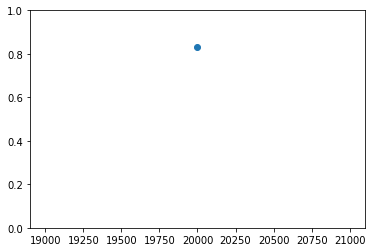

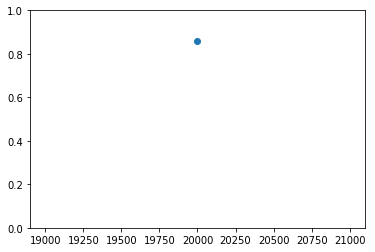

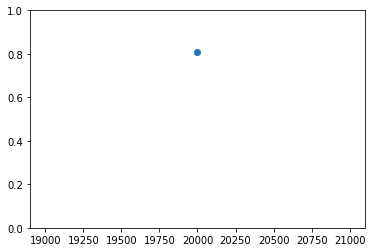

In [14]:
plt.figure()
plt.plot(sizes,F1[:,0],'o')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.plot(sizes,PREC[:,0],'o')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.plot(sizes,REC[:,0],'o')
plt.ylim(0,1)
plt.show()

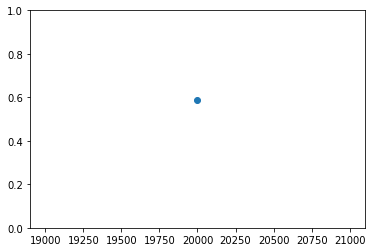

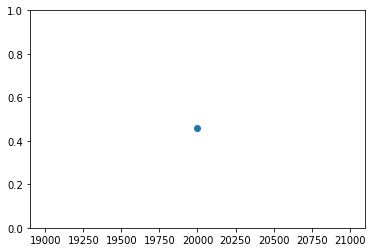

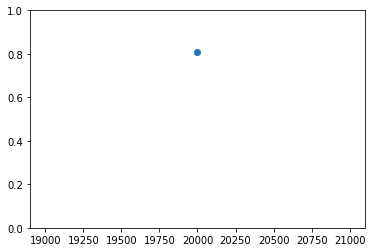

In [15]:
plt.figure()
plt.plot(sizes,F1[:,2],'o')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.plot(sizes,PREC[:,2],'o')
plt.ylim(0,1)
plt.show()
plt.figure()
plt.plot(sizes,REC[:,2],'o')
plt.ylim(0,1)
plt.show()

In [16]:
def show_pred(pred,dim):
    plt.figure(figsize=(10,10))
    plt.imshow(np.reshape(pred,(dim)),cmap="gray")
    plt.show()
    

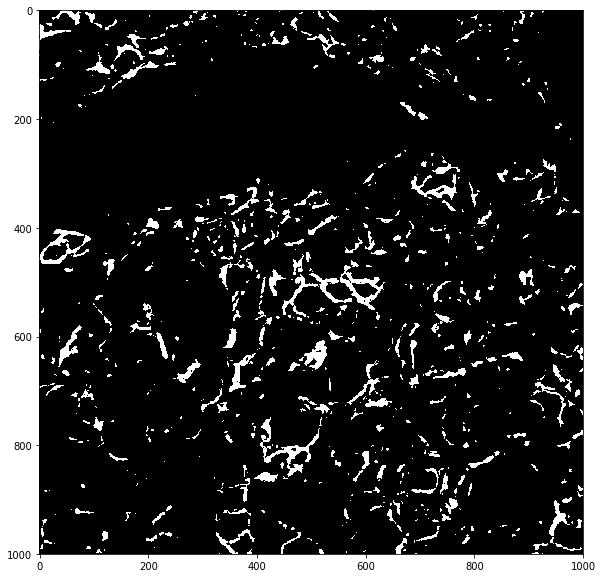

In [17]:
show_pred(pred_big_im,(1000,1000))

# Analyzing bronw 

## 1- blue

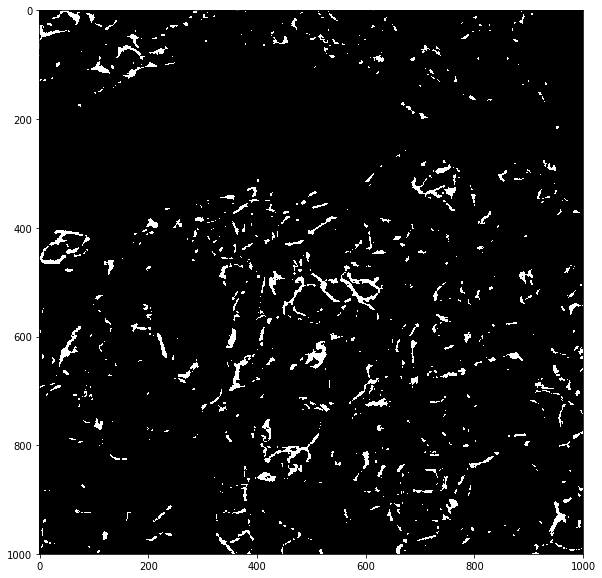

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(blue,(1000,1000))<0.3,cmap="gray")
plt.show()

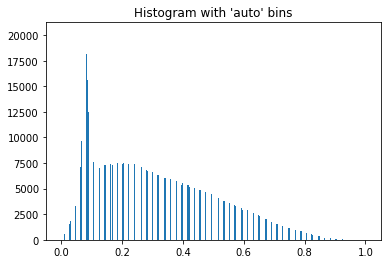

In [19]:
measure_bronw(1-blue,t=1000)

## DAB

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(dab,(1000,1000))>0.55,cmap="gray")
plt.show()

NameError: name 'dab' is not defined

In [ ]:
measure_bronw(dab)